## Import Statements

In [1]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [2]:
data_path = '../Data/'

filenames = [
#     'CM2014_edit.csv',
    'CM2015_edit.csv',
    'CM2016_edit.csv',
    'CM2017_edit.csv',
    'CM2018_edit.csv',
    'mdcp.csv',
    'major_ion.csv',
    'Weather_Data.csv'
]

# cla_2014 = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2015_raw = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2016_raw = pd.read_csv(data_path + filenames[1], low_memory=False)
cla_2017_raw = pd.read_csv(data_path + filenames[2], low_memory=False)
cla_2018_raw = pd.read_csv(data_path + filenames[3], low_memory=False)
mdcp_raw = pd.read_csv(data_path + filenames[4], low_memory=False)    # Mendota buoy
weather_raw = pd.read_csv(data_path + filenames[6], error_bad_lines=False, low_memory=False)

## Clean Data

### CLA Data

In [3]:
keep15 = [     # features to keep for years 2015-2017
    'correct_timestamp',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'lat',
    'long'
]

keep18 = [    # features to keep for 2018
    'sample_collection_time',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitiude',
    'longitude'
]

rename15 = {   # rename features for 2015-2017
    'collectionSiteId': 'site',
    'lat': 'latitude',
    'long': 'longitude',
    'correct_timestamp': 'date'
}

rename18 = {   # renamce features for 2018
    'collectionSiteId': 'site',
    'sample_collection_time': 'date',
    'latitiude': 'latitude'
}

cla_2015 = cla_2015_raw[keep15]
cla_2016 = cla_2016_raw[keep15]
cla_2017 = cla_2017_raw[keep15]
cla_2018 = cla_2018_raw[keep18]

cla_2015.rename(rename15, axis='columns', inplace=True)
cla_2016.rename(rename15, axis='columns', inplace=True)
cla_2017.rename(rename15, axis='columns', inplace=True)
cla_2018.rename(rename18, axis='columns', inplace=True)

# change data types
numeric = [    # list of numeric features
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitude',
    'longitude'
]

# convert data types
features = cla_2015.columns.values

for feat in features:
    if feat in numeric:
        cla_2015[feat] = pd.to_numeric(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_numeric(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_numeric(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_numeric(cla_2018[feat], errors='coerce')
    
    if feat in ['site', 'lake']:
        cla_2015[feat] = cla_2015[feat].astype(str)
        cla_2016[feat] = cla_2016[feat].astype(str)
        cla_2017[feat] = cla_2017[feat].astype(str)
        cla_2018[feat] = cla_2018[feat].astype(str)
    
    if feat == 'date':
        cla_2015[feat] = pd.to_datetime(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_datetime(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_datetime(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_datetime(cla_2018[feat], errors='coerce')
        
# remove nans
cla_2015.dropna(axis='rows', how='any', inplace=True)
cla_2016.dropna(axis='rows', how='any', inplace=True)
cla_2017.dropna(axis='rows', how='any', inplace=True)
cla_2018.dropna(axis='rows', how='any', inplace=True)

# remove any data point not on lake mendota
cla_2015 = cla_2015[cla_2015['lake'].str.contains('Mendota')]
cla_2016 = cla_2016[cla_2016['lake'].str.contains('Mendota')]
cla_2017 = cla_2017[cla_2017['lake'].str.contains('Mendota')]
cla_2018 = cla_2018[cla_2018['lake'].str.contains('Mendota')]

# set date as index
cla_2015.set_index('date', inplace=True)
cla_2016.set_index('date', inplace=True)
cla_2017.set_index('date', inplace=True)
cla_2018.set_index('date', inplace=True)

# sort data by dates
cla_2015.sort_values(by='date', inplace=True)
cla_2016.sort_values(by='date', inplace=True)
cla_2017.sort_values(by='date', inplace=True)
cla_2018.sort_values(by='date', inplace=True)

# resample, ffill and bfill
cla_2015 = cla_2015.resample('D').mean()
cla_2015.ffill(inplace=True)
cla_2015.bfill(inplace=True)

for date in cla_2015.index:
    if cla_2015.loc[date, 'algalBloomSheen'] > 0:
        cla_2015.loc[date, 'algalBloomSheen'] = 1

cla_2016 = cla_2016.resample('D').mean()
cla_2016.ffill(inplace=True)
cla_2016.bfill(inplace=True)

for date in cla_2016.index:
    if cla_2016.loc[date, 'algalBloomSheen'] > 0:
        cla_2016.loc[date, 'algalBloomSheen'] = 1

cla_2017 = cla_2017.resample('D').mean()
cla_2017.ffill(inplace=True)
cla_2017.bfill(inplace=True)

for date in cla_2017.index:
    if cla_2017.loc[date, 'algalBloomSheen'] > 0:
        cla_2017.loc[date, 'algalBloomSheen'] = 1

cla_2018 = cla_2018.resample('D').mean()
cla_2018.ffill(inplace=True)
cla_2018.bfill(inplace=True)

for date in cla_2018.index:
    if cla_2018.loc[date, 'algalBloomSheen'] > 0:
        cla_2018.loc[date, 'algalBloomSheen'] = 1

### MDCP Data

In [4]:
keep_mdcp = [
    'sampledate',
    'sampletime',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor',
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]

mdcp = mdcp_raw[keep_mdcp]
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

mdcp['date'] = mdcp['sampledate'] + ' ' + mdcp['sampletime']
mdcp['date'] = pd.to_datetime(mdcp['date'], errors='coerce')
mdcp.dropna(axis='rows', how='any', inplace=True)

mdcp = mdcp[[
    'date',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor', 
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]]
mdcp.set_index('date', inplace=True)

mdcp = mdcp.resample('D').mean()
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

### Weather Data

In [5]:
keep_weather = [
    'DATE',
    'REPORTTPYE',
    'DAILYMaximumDryBulbTemp',
    'DAILYMinimumDryBulbTemp',
    'DAILYAverageDryBulbTemp',
    'DAILYDeptFromNormalAverageTemp',
    'DAILYAverageDewPointTemp',
    'DAILYAverageWetBulbTemp',
    'DAILYPrecip',
    'DAILYAverageStationPressure',
    'DAILYAverageSeaLevelPressure'
]

weather = weather_raw[keep_weather]
weather.dropna(axis='rows', how='any', inplace=True)

weather = weather[weather['REPORTTPYE'].str.contains('SOD')]    # only keep summary of day (SOD) info
weather = weather.drop(['REPORTTPYE'], axis='columns')
weather['DATE'] = pd.to_datetime(weather['DATE'], errors='coerce')

weather.set_index('DATE', inplace=True)
weather = weather.resample('D').ffill()
weather.bfill(inplace=True)

## Join CLA, MDCP, and Weather Data

In [7]:
# Append CLA data
cla = cla_2015.append(cla_2016)
cla = cla.append(cla_2017)
cla = cla.append(cla_2018)

# Insert MDCP data
data = cla.join(mdcp, how='inner')

# Insert weather data
data = data.join(weather, how='inner')

# sine/cosine transformation of month of year and wind direction
data['cos_month'] = np.cos(2 * np.pi * (data.index.month.values / 12))
data['sin_month'] = np.sin(2 * np.pi * (data.index.month.values / 12))

data['cos_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data['sin_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data = data.drop(['wind_dir'], axis='columns')

# Replace 'T' and 's' in 'DAILYPrecip' column
for date in data.index:
    if 'T' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0.01
    elif 's' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0

# Make every feature numeric
for col in data.columns.values:
    if type(data[col].values[0]) != np.float64:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
# create indicator features for whether there was rain or a bloom one day ago, or within three days or a week ago
precip = (data['DAILYPrecip'] > 0).astype(int)   # convert precipitation to boolean values
data['DAILYPrecip_one_day'] = precip.shift(1)
data['DAILYPrecip_three_day'] = precip.rolling(3).sum()
data['DAILYPrecip_one_week'] = precip.rolling(7).sum()

data['algalBloomSheen_one_day'] = data['algalBloomSheen'].shift(1)
data['algalBloomSheen_three_day'] = data['algalBloomSheen'].rolling(3).sum()
data['algalBloomSheen_one_week'] = data['algalBloomSheen'].rolling(7).sum()

data.dropna(axis='rows', how='any', inplace=True)

labels = data[['algalBloomSheen']]
data = data.drop(['algalBloom', 'algalBloomSheen'], axis='columns')

## Define Models

In [34]:
logic = LogisticRegression(    # gives more false positives, but not so many false negatives!!!!!
    penalty='l1',              # this model might be better without weather data actually
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

svc = SVC(                     # gives even slightly fewer false negatives than logic
    C=1,
    kernel='poly',
    degree=6,
    gamma='auto',
    coef0=1,
    probability=True,
    tol=0.001,
    class_weight='balanced',
    max_iter=10000
)

rfc = RandomForestClassifier(       # BEST MODEL
    n_estimators=100,
    max_depth=6,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced'
)

mlp = MLPClassifier(
    hidden_layer_sizes=(20, 50, 50, 20),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=8,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    tol=0.0001,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    n_iter_no_change=10
)

model = rfc

########################################
########################################
########################################
# TODO TRY PARAMETER TUNING THE SVC AND RFC, WILL POLY SVC WORK??
# TODO TRY CHANGING ROLLING AND SHIFTED BOOLEAN PRECIP DATA TO ACTUAL AMOUNTS   -- DONE!!
# TODO TRY LOG TRANSFORMS AND OTHERWISE ON SOME FEATURES
# TODO CROSS VALIDATED TRAINING CURVE                                 -- NOT APPLICABLE!!
# TODO TRY TRAINING ON ALL DATA BEFORE 2018, AND TEST ON DATA AFTER   -- DONE!!
# TODO TRY USING DATA ONLY FROM SAMPLING SEASON
# TODO TRY USING 2014 DATA
# TODO ALSO TRY PARAMETER TUNING ON LOGISTIC REGRESSION
# TODO TRY ONLY OPTIMIZING F1 SCORE WHEN PARAMETER TUNING
########################################
########################################
########################################

## Run Model (Predict on 2018)

In [54]:
train_val_years = [2015, 2016, 2017]

rfc_params = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11]
}

best_f1_roc = 0     # The harmonic mean of F1 and ROC AUC Scores is best
best_params = {}

for est in rfc_params['n_estimators']:
    for cri in rfc_params['criterion']:
        for dep in rfc_params['max_depth']:
            model = RandomForestClassifier(
                n_estimators=est,
                criterion=cri,
                max_depth=dep,
                bootstrap=True,
                class_weight='balanced'
            )
            
            train_acc = []
            train_f1 = []
            train_roc = []
            
            val_acc = []
            val_f1 = []
            val_roc = []
            
            f1_roc = []
            
            conf_matrix = np.zeros(shape=(2, 2))
            
            for i in range(len(train_val_years)-1):
                X_train = data[data.index.year <= train_val_years[i]].values
                X_val = data[data.index.year == train_val_years[i+1]].values

                y_train = labels[labels.index.year <= train_val_years[i]].values
                y_val = labels[labels.index.year == train_val_years[i+1]].values

                y_train = np.reshape(y_train.astype(int), newshape=(X_train.shape[0]))
                y_val = np.reshape(y_val.astype(int), newshape=(X_val.shape[0]))
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                y_prob = model.predict_proba(X_val)[:, 1]

                train_acc.append(model.score(X_train, y_train))
                train_f1.append(f1_score(y_train, model.predict(X_train), average='weighted'))
                train_roc.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1], average='weighted'))

                val_acc.append(model.score(X_val, y_val))
                val_f1.append(f1_score(y_val, y_pred, average='weighted'))
                val_roc.append(roc_auc_score(y_val, y_prob, average='weighted'))

                conf_matrix += confusion_matrix(y_val, y_pred)

                f1_roc.append((2 * val_roc[i] * val_f1[i]) / (val_roc[i] + val_f1[i]))
                
            avg_train_acc = sum(train_acc) / (len(train_val_years)-1)
            avg_train_f1 = sum(train_f1) / (len(train_val_years)-1)
            avg_train_roc = sum(train_roc) / (len(train_val_years)-1)
            
            avg_val_acc = sum(val_acc) / (len(train_val_years)-1)
            avg_val_f1 = sum(val_f1) / (len(train_val_years)-1)
            avg_val_roc = sum(val_roc) / (len(train_val_years)-1)
            
            conf_matrix /= (len(train_val_years)-1)
            
            avg_f1_roc = sum(f1_roc) / (len(train_val_years)-1)
            
            if avg_f1_roc > best_f1_roc:
                best_f1_roc = avg_f1_roc
                best_params['n_estimators'] = est
                best_params['criterion'] = cri
                best_params['max_depth'] = dep
                best_conf_matrix = conf_matrix

                
            print('Results for n_estimators=' + str(est) + ', criterion=' + str(cri) + ', max_depth=' + str(dep))
            print('Average Train Accuracy: %0.4f' % avg_train_acc)
            print('Average Train F1 Score: %0.4f' % avg_train_f1)
            print('Average Train ROC AUC: %0.4f\n' % avg_train_roc)

            print('Average Validation Accuracy: %0.4f' % avg_val_acc)
            print('Average Validation F1 Score: %0.4f' % avg_val_f1)
            print('Average Validation ROC AUC: %0.4f' % avg_val_roc)
            print()
            print('Average Harmonic Mean of F1 Score and ROC AUC Score: %0.4f' % avg_f1_roc)
            
            print('\nAverage Confusion Matrix:\n')
            print(pd.DataFrame(conf_matrix))
            print('\n\n\n')
            
print('Best Average F1-ROC AUC Score: %0.4f' % best_f1_roc)
print('Best Model Parameters:')
print(best_params)
print('Best Confusion Matrix:')
print(best_conf_matrix)
print('\n\n\n')

Results for n_estimators=10, criterion=gini, max_depth=3
Average Train Accuracy: 0.8879
Average Train F1 Score: 0.8914
Average Train ROC AUC: 0.9756

Average Validation Accuracy: 0.8459
Average Validation F1 Score: 0.8478
Average Validation ROC AUC: 0.8723

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8593

Average Confusion Matrix:

       0     1
0  113.0  17.5
1    9.5  33.0




Results for n_estimators=10, criterion=gini, max_depth=4
Average Train Accuracy: 0.9127
Average Train F1 Score: 0.9153
Average Train ROC AUC: 0.9816

Average Validation Accuracy: 0.7820
Average Validation F1 Score: 0.7877
Average Validation ROC AUC: 0.8043

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.7954

Average Confusion Matrix:

       0     1
0  108.5  22.0
1   15.5  27.0




Results for n_estimators=10, criterion=gini, max_depth=5
Average Train Accuracy: 0.9501
Average Train F1 Score: 0.9512
Average Train ROC AUC: 0.9918

Average Validation Accuracy: 0.8271
Average Validation F1 Sc

Results for n_estimators=20, criterion=gini, max_depth=8
Average Train Accuracy: 0.9928
Average Train F1 Score: 0.9929
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.8089
Average Validation F1 Score: 0.7964
Average Validation ROC AUC: 0.8643

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8272

Average Confusion Matrix:

       0     1
0  120.0  10.5
1   23.5  19.0




Results for n_estimators=20, criterion=gini, max_depth=9
Average Train Accuracy: 0.9924
Average Train F1 Score: 0.9925
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.7972
Average Validation F1 Score: 0.7677
Average Validation ROC AUC: 0.8477

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8033

Average Confusion Matrix:

       0     1
0  123.5   7.0
1   29.0  13.5




Results for n_estimators=20, criterion=gini, max_depth=10
Average Train Accuracy: 0.9964
Average Train F1 Score: 0.9964
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.8025
Average Validation F1 S

Results for n_estimators=50, criterion=entropy, max_depth=3
Average Train Accuracy: 0.8767
Average Train F1 Score: 0.8809
Average Train ROC AUC: 0.9790

Average Validation Accuracy: 0.8387
Average Validation F1 Score: 0.8420
Average Validation ROC AUC: 0.8720

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8563

Average Confusion Matrix:

       0     1
0  113.5  17.0
1   11.0  31.5




Results for n_estimators=50, criterion=entropy, max_depth=4
Average Train Accuracy: 0.9343
Average Train F1 Score: 0.9368
Average Train ROC AUC: 0.9916

Average Validation Accuracy: 0.8257
Average Validation F1 Score: 0.8308
Average Validation ROC AUC: 0.8874

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8577

Average Confusion Matrix:

       0     1
0  110.0  20.5
1   10.0  32.5




Results for n_estimators=50, criterion=entropy, max_depth=5
Average Train Accuracy: 0.9544
Average Train F1 Score: 0.9556
Average Train ROC AUC: 0.9960

Average Validation Accuracy: 0.8400
Average Validat

Results for n_estimators=100, criterion=entropy, max_depth=6
Average Train Accuracy: 0.9785
Average Train F1 Score: 0.9790
Average Train ROC AUC: 0.9991

Average Validation Accuracy: 0.8342
Average Validation F1 Score: 0.8314
Average Validation ROC AUC: 0.8580

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8436

Average Confusion Matrix:

       0     1
0  117.5  13.0
1   16.0  26.5




Results for n_estimators=100, criterion=entropy, max_depth=7
Average Train Accuracy: 0.9946
Average Train F1 Score: 0.9947
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.8459
Average Validation F1 Score: 0.8426
Average Validation ROC AUC: 0.8772

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8589

Average Confusion Matrix:

       0     1
0  119.5  11.0
1   16.0  26.5




Results for n_estimators=100, criterion=entropy, max_depth=8
Average Train Accuracy: 1.0000
Average Train F1 Score: 1.0000
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.8355
Average Vali

Results for n_estimators=200, criterion=entropy, max_depth=9
Average Train Accuracy: 1.0000
Average Train F1 Score: 1.0000
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.8400
Average Validation F1 Score: 0.8290
Average Validation ROC AUC: 0.9019

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8635

Average Confusion Matrix:

       0     1
0  123.5   7.0
1   21.0  21.5




Results for n_estimators=200, criterion=entropy, max_depth=10
Average Train Accuracy: 1.0000
Average Train F1 Score: 1.0000
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.8336
Average Validation F1 Score: 0.8211
Average Validation ROC AUC: 0.8878

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8516

Average Confusion Matrix:

       0     1
0  123.0   7.5
1   22.0  20.5




Results for n_estimators=200, criterion=entropy, max_depth=11
Average Train Accuracy: 1.0000
Average Train F1 Score: 1.0000
Average Train ROC AUC: 1.0000

Average Validation Accuracy: 0.8355
Average Va

Results for n_estimators=1000, criterion=gini, max_depth=3
Average Train Accuracy: 0.8904
Average Train F1 Score: 0.8942
Average Train ROC AUC: 0.9797

Average Validation Accuracy: 0.8459
Average Validation F1 Score: 0.8461
Average Validation ROC AUC: 0.8819

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8631

Average Confusion Matrix:

       0     1
0  116.0  14.5
1   12.5  30.0




Results for n_estimators=1000, criterion=gini, max_depth=4
Average Train Accuracy: 0.9339
Average Train F1 Score: 0.9362
Average Train ROC AUC: 0.9912

Average Validation Accuracy: 0.8543
Average Validation F1 Score: 0.8536
Average Validation ROC AUC: 0.8800

Average Harmonic Mean of F1 Score and ROC AUC Score: 0.8662

Average Confusion Matrix:

       0     1
0  117.5  13.0
1   12.5  30.0




Results for n_estimators=1000, criterion=gini, max_depth=5
Average Train Accuracy: 0.9709
Average Train F1 Score: 0.9716
Average Train ROC AUC: 0.9973

Average Validation Accuracy: 0.8400
Average Validation

First: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 8}        ~0.86
Second: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 10}   ~0.84
Third: {'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 10}    ~0.84 
Fourth: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 4}    ~0.84
Fifth: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 8}      0.8489
Sixth: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 9}         0.8755

With time series cross validation
First: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 3}      0.8733
Second: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 3}     0.8757
Third: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 6}      0.8767
Fourth: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 5}    0.8736
Fifth: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 5}      0.8718
Sixth: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': 4}        0.8692
Seventh: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 6}   0.8724

In [57]:
best_rfc = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    criterion=best_params['criterion'],
    bootstrap=True,
    class_weight='balanced'
)

# best_rfc = RandomForestClassifier(
#     n_estimators=20,
#     max_depth=3,
#     criterion='entropy',
#     bootstrap=True,
#     class_weight='balanced'
# )

X_train = data[data.index.year < 2018].values
X_test = data[data.index.year == 2018].values

y_train = labels[labels.index.year < 2018].values
y_test = labels[labels.index.year == 2018].values

y_train = np.reshape(y_train.astype(int), newshape=(X_train.shape[0]))
y_test = np.reshape(y_test.astype(int), newshape=(X_test.shape[0]))

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

best_rfc.fit(X_train, y_train)
y_pred = best_rfc.predict(X_test)
y_prob = best_rfc.predict_proba(X_test)[:, 1]

train_acc = best_rfc.score(X_train, y_train)
train_f1 = f1_score(y_train, best_rfc.predict(X_train), average='weighted')
train_roc = roc_auc_score(y_train, best_rfc.predict_proba(X_train)[:, 1], average='weighted')

test_acc = best_rfc.score(X_test, y_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_roc = roc_auc_score(y_test, y_prob, average='weighted')

conf_matrix = confusion_matrix(y_test, y_pred)

print('Train Accuracy: %0.4f' % train_acc)
print('Train F1 Score: %0.4f' % train_f1)
print('Train ROC AUC: %0.4f\n' % train_roc)

print('Test Accuracy: %0.4f' % test_acc)
print('Test F1 Score: %0.4f' % test_f1)
print('Test ROC AUC: %0.4f' % test_roc)

print('\nAverage Confusion Matrix:\n')
print(pd.DataFrame(conf_matrix))
print('\n\n\n')

Train Accuracy: 0.9195
Train F1 Score: 0.9223
Train ROC AUC: 0.9965

Test Accuracy: 0.8000
Test F1 Score: 0.7891
Test ROC AUC: 0.8937

Average Confusion Matrix:

    0   1
0  26  19
1   1  54






## Run Model

In [9]:
X = data.values
y = np.reshape(labels.values.astype(int), newshape=(X.shape[0]))

num_folds = 10

sss = StratifiedShuffleSplit(n_splits=num_folds)
scaler = StandardScaler()

train_acc = []
train_f1 = []
train_roc = []
test_acc = []
test_f1 = []
test_roc = []
conf_matrix = np.zeros(shape=(2, 2))

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    train_acc.append(model.score(X_train, y_train))
    train_f1.append(f1_score(y_train, model.predict(X_train), average='weighted'))
    train_roc.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1], average='weighted'))
    
    test_acc.append(model.score(X_test, y_test))
    test_f1.append(f1_score(y_test, y_pred, average='weighted'))
    test_roc.append(roc_auc_score(y_test, y_prob, average='weighted'))
    
    conf_matrix += confusion_matrix(y_test, y_pred)

conf_matrix = conf_matrix / num_folds

print('Average Train Accuracy: %0.4f' % (sum(train_acc) / num_folds))
print('Average Train F1 Score: %0.4f' % (sum(train_f1) / num_folds))
print('Average Train ROC AUC: %0.4f\n' % (sum(train_roc) / num_folds))

print('Average Test Accuracy: %0.4f' % (sum(test_acc) / num_folds))
print('Average Test F1 Score: %0.4f' % (sum(test_f1) / num_folds))
print('Average Test ROC AUC: %0.4f' % (sum(test_roc) / num_folds))
print('\nConfusion Matrix:\n')

print(pd.DataFrame(conf_matrix))

Average Train Accuracy: 0.9074
Average Train F1 Score: 0.9094
Average Train ROC AUC: 0.9837

Average Test Accuracy: 0.8276
Average Test F1 Score: 0.8314
Average Test ROC AUC: 0.9309

Confusion Matrix:

      0     1
0  31.5   7.5
1   2.5  16.5


## Run Single Instance of Model

In [52]:
X = data.values
y = np.reshape(labels.values.astype(int), newshape=(X.shape[0]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

train_acc = model.score(X_train, y_train)
train_f1 = f1_score(y_train, model.predict(X_train), average='weighted')
train_roc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1], average='weighted')

test_acc = model.score(X_test, y_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_roc = roc_auc_score(y_test, y_prob, average='weighted')

conf_matrix = confusion_matrix(y_test, y_pred)

print('Average Train Accuracy: %0.4f' % train_acc)
print('Average Train F1 Score: %0.4f' % train_f1)
print('Average Train ROC AUC: %0.4f\n' % train_roc)

print('Average Test Accuracy: %0.4f' % test_acc)
print('Average Test F1 Score: %0.4f' % test_f1)
print('Average Test ROC AUC: %0.4f' % test_roc)
print('\nConfusion Matrix:\n')

print(pd.DataFrame(conf_matrix))

Average Train Accuracy: 0.8975
Average Train F1 Score: 0.8997
Average Train ROC AUC: 0.9802

Average Test Accuracy: 0.8488
Average Test F1 Score: 0.8518
Average Test ROC AUC: 0.9319

Confusion Matrix:

    0   1
0  99  18
1   8  47


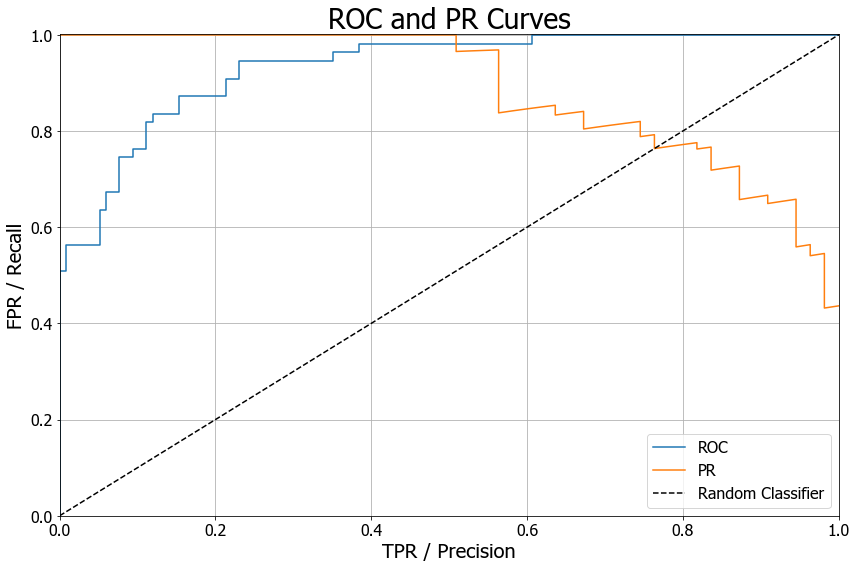

In [53]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
prec, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label='ROC')
plt.plot(recall, prec, label='PR')
plt.plot(0.1*np.arange(12), 0.1*np.arange(12), color="k", linestyle="dashed", label="Random Classifier")
plt.xlabel('FPR / Recall', fontsize=20)
plt.ylabel('TPR / Precision', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0, 1, 0, 1.001])
plt.title('ROC and PR Curves', fontsize=28)
plt.legend(loc="lower right", prop={"size": 16})
plt.tight_layout()
plt.grid(True)
#savefig("roc-curve.png", dpi=300)